In [1]:
import matplotlib.pyplot as plt, numpy as np, numpy.random as npr, csv, matplotlib.pyplot as plt, pandas as pd
import torch.nn as nn, timeit, torch, pystan as ps
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import LocallyLinearEmbedding
from tqdm import trange
%matplotlib inline
from time import time
from pylab import plot, show, legend

In [2]:
sm = ps.StanModel(file="/home/postdoc/dsen/Desktop/VAE_density/stan_files/nn_refpoints.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6f58d235465c773e740a890b0262cc7f NOW.


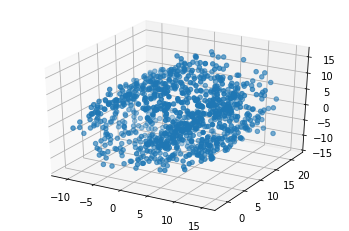

In [3]:
Y, t = datasets.make_swiss_roll(n_samples=1000, noise=1e0, random_state=None)
Y = Y.transpose()
Nobs = np.shape(Y)[1]

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(Y[0], Y[1], Y[2])

### Local linear embedding for reference points:

In [4]:
n_ref = 0
lat_dim = 2
obs_dim = np.shape(Y)[0] 
ref_points = npr.choice(Nobs,n_ref,replace=False)
embedding = LocallyLinearEmbedding(n_components=2,n_neighbors=10)
Y_embedded = embedding.fit_transform(Y.transpose()).transpose()

In [5]:
train = np.setdiff1d(np.arange(Nobs), ref_points)
Y_ref = Y[:,ref_points]
X_ref = Y_embedded[:,ref_points]
Y_train = Y[:,train]

In [6]:
n_in = np.shape(Y_embedded)[0]
n_out = np.shape(Y)[0]
n_h = 15

In [7]:
data = dict(Nobs=Nobs, in_dim=n_in, out_dim=n_out, hidden_dim=n_h,
            n_ref=np.shape(Y_ref)[1], y=Y_train, y_ref=Y_ref, X_ref=X_ref)

### Run Stan:

In [ ]:
start = time()
fit = sm.sampling(data=data, thin=1, n_jobs=10, chains=10, init="random", iter=1000)
print(round((time()-start)/60,2), "minutes to run")
print(fit);

In [ ]:
trace = fit.extract()
n_samples, n_latent = np.shape(trace['X'])[0], np.shape(trace['X'])[1]

### Traceplots of latent variables:

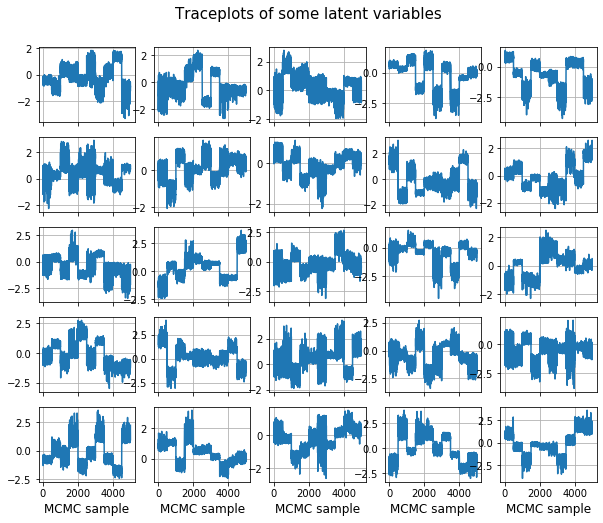

In [10]:
plt.figure(figsize=(10,8))
idx = npr.choice(n_latent,25).reshape(5,5)

for i in range(5):
    for j in range(5):
        k = 5*i+j
        plt.subplot(5,5,k+1)
        plt.plot(trace['X'][:,idx[i,j],0])
        if i < 4 : plt.xticks(alpha=0)
        if i == 4 : plt.xlabel("MCMC sample", fontsize=12)
        plt.grid(True)
plt.suptitle("Traceplots of some latent variables", fontsize=15, x=0.5,y=0.95)
plt.show()

### Loss:

100%|██████████| 5000/5000 [00:01<00:00, 2785.75it/s]


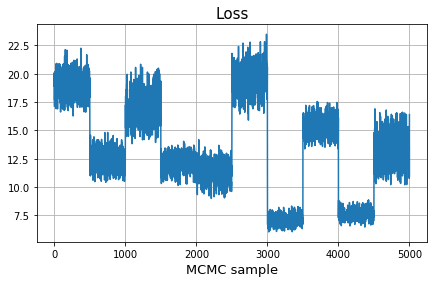

In [11]:
def L2_loss(X, Z, weights_1, bias_1, weights_2, bias_2) :
    X_pred = np.matmul(np.tanh(np.matmul(Z,weights_1)+bias_1), weights_2) + bias_2
    return np.mean(np.sum((X-X_pred)**2,axis=1))
loss = np.zeros(n_samples)
for i in trange(n_samples) :
    loss[i] = L2_loss(Y_train.transpose(), trace['X'][i], trace['weights_1'][i], 
                      trace['bias_1'][i], trace['weights_2'][i], trace['bias_2'][i])
plt.figure(figsize=(7,4))
plt.plot(loss)
plt.title("Loss", fontsize=15)
plt.xlabel("MCMC sample", fontsize=13)
plt.grid(True)

### Pairwise distances:

In [12]:
k_max = 50

pw_dist_matrix = np.zeros((n_latent,n_latent,n_samples))
for k in trange(n_samples) :
    for i in range(k_max) :
        for j in range(k_max) :
            pw_dist_matrix[i,j,k] = np.linalg.norm(trace['X'][k,i]-trace['X'][k,j])

100%|██████████| 5000/5000 [01:24<00:00, 58.86it/s]


Text(0.31, 0.83, 'Traceplots of some pairwise distances of latent variables for hypersphere')

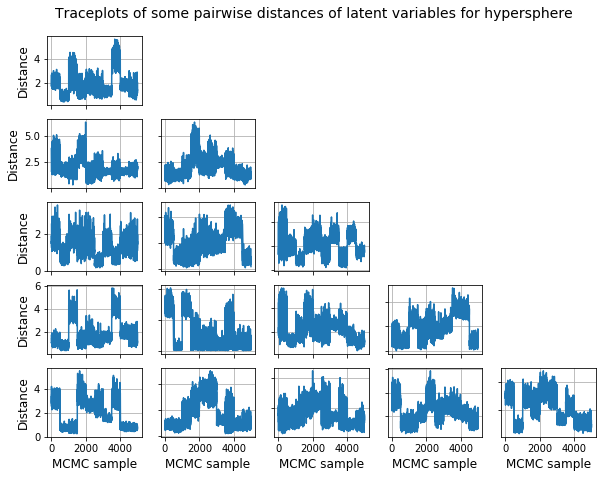

In [13]:
idx = npr.choice(k_max,10,replace=False)
plt.figure(figsize=(20,15))
for i in range(6):
    for j in range(6):
        if i > j :
            k = 10*i+j+1
            plt.subplot(10,10,k)
            plt.plot(pw_dist_matrix[idx[i],idx[j]])
            if i < 5 : plt.xticks(alpha=0)
            plt.grid(True)
            if i == 5 : plt.xlabel("MCMC sample", fontsize=12)
            if j > 0 : plt.yticks(alpha=0)
            if j == 0 : plt.ylabel("Distance", fontsize=12)
plt.suptitle("Traceplots of some pairwise distances of latent variables for hypersphere", fontsize=14, x=0.31,y=0.83)
# plt.savefig('/home/postdoc/dsen/Desktop/VAE_density/plots/swissroll_pwdist_unconstrainedW1_refpoints.pdf', 
#                 dpi=2000, bbox_inches='tight');